## Goal Generator

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
class AlternatingGoalGenerator():
    def __init__(self, base_goal_loc_map, next_goal_loc_map):
        self.base_goal_loc_map = base_goal_loc_map
        self.next_goal_loc_map = next_goal_loc_map
        self.is_env_set = False
        self.env = None 
        
    def get_new_location(self, agent_id):
        if not self.is_env_set:
            raise ValueError("Env is not set yet.")
        
        agent_loc = self.env.agent_state[agent_id]
        goal_loc = self.env.agent_goal[agent_id]
        next_goal_loc = self.next_goal_loc_map[goal_loc]
        
        return next_goal_loc
    
    def get_reset_location(self, agent_id):
        next_goal_loc = self.base_goal_loc_map[agent_id]
        return next_goal_loc
        
    def set_env(self, env):
        self.env = env
        self.is_env_set = True


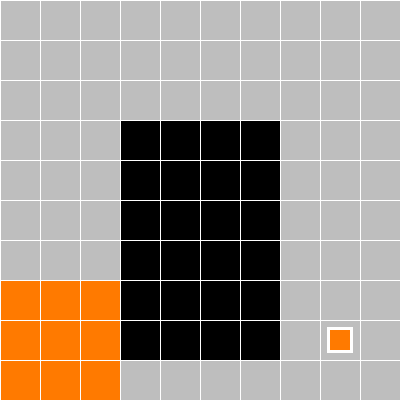

In [3]:
from warehouse_env.warehouse_env import WarehouseEnv
import numpy as np

env_shape = (10,10)

small_world = np.zeros(env_shape)
small_world[3:9, 3:7] = 1
small_agent= np.zeros(env_shape)
small_agent[7:, 0:3] = 1

base_goal_loc_map = {
    0: (8,8),
    1: (8,8),
    2: (8,8),
    3: (8,8),
    4: (8,8),
    5: (8,8),
    6: (8,8),
    7: (8,8),
    8: (8,8),
    9: (8,8),
}
next_goal_loc_map = {
    (8,8): (8,1),
    (8,1): (8,8)
}

goal_generator = AlternatingGoalGenerator(base_goal_loc_map, next_goal_loc_map)

small_env = WarehouseEnv(agent_map=np.array(small_agent), obstacle_map=np.array(small_world), 
                        local_obseration_size=(9,7), render_as_observation=True,
                        goal_generator=goal_generator,
                        delta_tolling=True,
                        delta_tolling_r=0.5,
                        delta_tolling_b=4.0)

small_env.render(zoom_size=40, local=False, draw_grid=True)

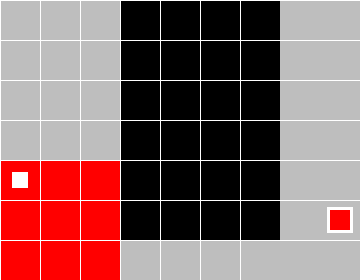

In [4]:
small_env.render(zoom_size=40, local=True, draw_grid=True)

In [5]:
from od_mstar3 import cpp_mstar
import networkx as nx

def get_next_action(env, env_graph, coordinated_planner=False):
    if coordinated_planner:
        states = [(v[0], v[1]) for k, v in env.agent_state.items()]
        goals = [(v[0], v[1]) for k, v in env.agent_goal.items()]
        path = None
        start_x, start_y = None, None
        next_x, next_y = None, None

        try:
            path = cpp_mstar.find_path(env.obstacle_map, states, goals, 10, 5 * 60.0)

            start_x, start_y = env.agent_state[env.current_agent_id]
            next_x, next_y = path[1][env.current_agent_id]   
        except:
            coordinated_planner = False

    if not coordinated_planner:
        location = env.agent_state[env.current_agent_id]
        goal = env.agent_goal[env.current_agent_id]

        path = nx.astar_path(env_graph, (location[0], location[1]), 
                             (goal[0], goal[1]), weight='weight')

        action = None
        start_x, start_y = path[0]
        next_x, next_y = path[1]
        
    if (start_y + 1)  == next_y:
        return_val = 0
    elif (start_y - 1) == next_y:
        return_val = 2
    elif (start_x - 1) == next_x:
        return_val = 1
    elif (start_x + 1) == next_x:
        return_val = 3
    else:
        return_val = 4
    
    return return_val

In [64]:
# Oscillating Goal Generator
small_env.delta_tolling = True
observation = small_env.reset()
frames = []
old_tolls = {}
for t in range(10000):
    frames.append(small_env.render(zoom_size=40, agent_id=None, draw_grid=True, local=False))
    action = get_next_action(small_env, small_env.env_graph, coordinated_planner=False)
    small_env.step(action)
    old_tolls[t] = small_env.toll_map.copy()
    
frames[0].save('gif/goal_generator_animation_astar_10000.gif',
               save_all=True, append_images=frames[1:], 
               optimize=False, duration=25, loop=0)

In [26]:
#
small_env.delta_tolling = False
# Oscillating Goal Generator
observation = small_env.reset()
frames = []
old_tolls = {}
for t in range(1000):
    frames.append(small_env.render(zoom_size=40, agent_id=None, draw_grid=True, local=False))
    action = get_next_action(small_env, small_env.env_graph, coordinated_planner=False)
    small_env.step(action)
    old_tolls[t] = small_env.toll_map.copy()
    
frames[0].save('gif/goal_generator_animation_astar_dt=off_1000.gif',
               save_all=True, append_images=frames[1:], 
               optimize=False, duration=25, loop=0)

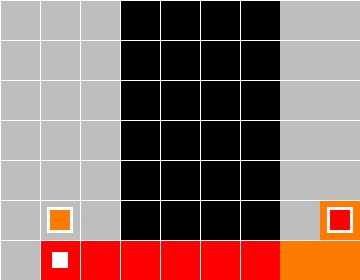

In [28]:
small_env.render(zoom_size=40, agent_id=0, draw_grid=True, local=True)

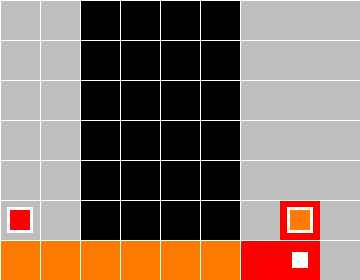

In [37]:
small_env.render(zoom_size=40, agent_id=5, draw_grid=True, local=True)

## RL Agent

In [6]:
from stable_baselines import A2C, A2CWithExperts

model_file = "/Users/pehuen/Downloads/log_14"
a2c_model = A2C.load(model_file + "/model.zip")

/Users/pehuen/opt/anaconda3/envs/primal2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/pehuen/opt/anaconda3/envs/primal2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/pehuen/opt/anaconda3/envs/primal2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/pehuen/opt/anaconda3/

Loading a model without an environment, this model cannot be trained until it has a valid environment.
self.processed_obs Tensor("input/truediv:0", shape=(?, 28, 36, 3), dtype=float32)
entities: Tensor("model/Reshape:0", shape=(?, 825, 64), dtype=float32)
layerNorm_mean (?, 825, 1)
MHDPA_output Tensor("model/MatMul_1:0", shape=(?, 2, 825, 64), dtype=float32)
residual_output Tensor("model/residualNet/Add:0", shape=(?, 2, 825, 64), dtype=float32)
maxpooling_output Tensor("model/Max:0", shape=(?, 2, 64), dtype=float32)
self.processed_obs Tensor("train_model/input/truediv:0", shape=(?, 28, 36, 3), dtype=float32)
entities: Tensor("train_model/model/Reshape:0", shape=(?, 825, 64), dtype=float32)
layerNorm_mean (?, 825, 1)
MHDPA_output Tensor("train_model/model/MatMul_1:0", shape=(?, 2, 825, 64), dtype=float32)
residual_output Tensor("train_model/model/residualNet/Add:0", shape=(?, 2, 825, 64), dtype=float32)
maxpooling_output Tensor("train_model/model/Max:0", shape=(?, 2, 64), dtype=float32)

In [38]:
#
small_env.delta_tolling = False
# Oscillating Goal Generator
observation = small_env.reset()
frames = []
old_tolls = {}
for t in range(1000):
    frames.append(small_env.render(zoom_size=40, agent_id=None, draw_grid=True, local=False))
    action, _states = a2c_model.predict(small_env._observe())#agent_id=0))
    small_env.step(action)
    old_tolls[t] = small_env.toll_map.copy()
    
frames[0].save('gif/goal_generator_animation_rl_dt=off_1000.gif',
               save_all=True, append_images=frames[1:], 
               optimize=False, duration=25, loop=0)


In [47]:
#
small_env.delta_tolling = True
# Oscillating Goal Generator
observation = small_env.reset()
frames = []
old_tolls = {}
for t in range(1000):
    frames.append(small_env.render(zoom_size=40, agent_id=None, draw_grid=True, local=False))
    action, _states = a2c_model.predict(small_env._observe())#agent_id=0))
    small_env.step(action)
    old_tolls[t] = small_env.toll_map.copy()
    
frames[0].save('gif/goal_generator_animation_rl_dt=on_1000.gif',
               save_all=True, append_images=frames[1:], 
               optimize=False, duration=25, loop=0)


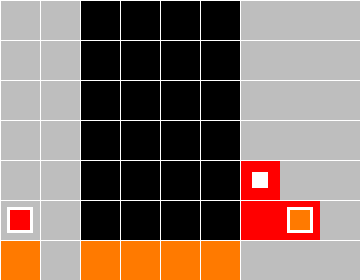

In [50]:
small_env.render(zoom_size=40, agent_id=8, draw_grid=True, local=True)